# HPC Assignment 2 - GPU Computing

# Part 1: Solving a wave problem with sparse matrices

In this part I will be solving a simple harmonic oscillator. The differential equation that describes it is shown below:

$$
\frac{d^2u}{dx^2} + k^2u = 0
$$
When u = 0, x = 0 and when u = 1, x = 1 with wavenumber $k = \frac{29\pi}{2}$. This problem will be solved using the method of finite differences by taking evenly spaced values between 0 and 1 for x with indexes 0 to N and approximating the u value for each value. The below equation will be used where h=1/N. $$\frac{d^2u_i}{dx^2} \approx  \frac{u_{i-1} -2u_i + u_{i+1}}{h^2}$$

We can rewrite the problem as $$ (2 - h^2k^2)u_i - u_{i-1} - u_{i+1} = 0 $$

This can be phrased as the matrix vector problem $\textbf{Au} = \textbf{f} $. $\textbf{u}$ is an unknown vector to compute. Vectors $\textbf{f}$ and $\textbf{u}$ are described by:

$$
\begin{align*}
\left[\mathbf{u}\right]_i &= u_i,\\
\left[\mathbf{f}\right]_i &= \begin{cases}
1&\text{if }i=N,\\
0&\text{otherwise}.
\end{cases}
\end{align*}
$$
The rows of $\mathrm{A}$ are given by

$$
\left[\mathrm{A}\right]_{i,j} = 
\begin{cases}
1&\text{if }i=j,\\
0&\text{otherwise},
\end{cases}
$$
if $i=0$ or $i=N$; and

$$
\left[\mathrm{A}\right]_{i, j} = 
\begin{cases}
2-h^2k^2&\text{if }j=i,\\
-1&\text{if }j=i+1,\\
-1&\text{if }j=i-1.\\
0&\text{otherwise},
\end{cases}
$$
otherwise.


In [9]:
import numpy as np
from numba import cuda, njit, jit,prange
from scipy.sparse import coo_matrix,csr_matrix, linalg
import matplotlib.pyplot as plt
from tqdm import tqdm
import numba
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

In [12]:
def gen_Af_naive(N):
    """
    This function naively creates numpy arrays that satisfy A and f. 
    These matrices however are not sparse so not optimal for larger matrices.
    Inputs:
        N - Maximum index of matrix A and vector f. (int)
    Returns:
        A - (N+1) x (N+1) matrix (numpy array)
        f - (N+1) x 1 vector (numpy array)
    """
    A = np.zeros((N+1,N+1))
    f = np.zeros(N+1)
    f[-1] = 1
    h = 1/N
    k = 29*np.pi/2
    
    for i in range(1,N):
        A[i][i] = 2 - h**2 * k**2
        A[i][i-1] = -1
        A[i][i+1] = -1
    A[0][0] = 1
    A[-1][-1] = 1
    return A, f

Now I will create a matrix generator that generates sparse matrices.

In [63]:
def sparse_gen_Af(N,format = 'CSR'):
    """
    Inputs:
        N - maximum index of matrix and vector.
        format - specifies whether the maatrix uses COO or CSR sparse matrix format. (optional)
    """
    N = int(N)
    h = 1/N
    k = 29*np.pi/2

    row_index = np.arange(1,N,1)
    col_index = np.arange(0,N-1,1)
    if format == 'CSR':
        sparse_matrix = csr_matrix
    if format == 'COO':
        sparse_matrix = coo_matrix
    diagonal = [2 - h**2 * k**2]*(N-1)
    off_diagonal = [-1]*(N-1)
    f = sparse_matrix(([1],([N],[0])),shape = (N+1,1))
    A = sparse_matrix((diagonal,(row_index,row_index)),shape = (N+1,N+1))
    for i in (0,2):
        A += sparse_matrix((off_diagonal,(row_index,col_index + i)), shape = (N+1,N+1))
    A+= sparse_matrix(([1,1],([0,N],[0,N])),shape = (N+1,N+1))
    return A, f

In [14]:
sparse_gen_Af(4)[0].toarray()

array([[   1.        ,    0.        ,    0.        ,    0.        ,
           0.        ],
       [  -1.        , -127.69277033,   -1.        ,    0.        ,
           0.        ],
       [   0.        ,   -1.        , -127.69277033,   -1.        ,
           0.        ],
       [   0.        ,    0.        ,   -1.        , -127.69277033,
          -1.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           1.        ]])

Although the task asks for only A to be stored in a suitable matrix format, I have decided to store f in the same matrix format as well since it is extremely sparse. I have made the function above so that it can store matarices in both CSR and COO format. Below I will compare the two formats to see which is optimal. I will solve the diffferential specified above using the two matrix formats for a large matrix and compare times.

In [93]:
t1=[]
t2=[]
for N in [1000,10000,100000,10000000]:
    t_1 = %timeit -o -q linalg.spsolve(*sparse_gen_Af(N,format = 'CSR'))
    t_2 = %timeit -o -q linalg.spsolve(*sparse_gen_Af(N,format = 'COO'))
    t1.append(t_1.best)
    t2.append(t_2.best)

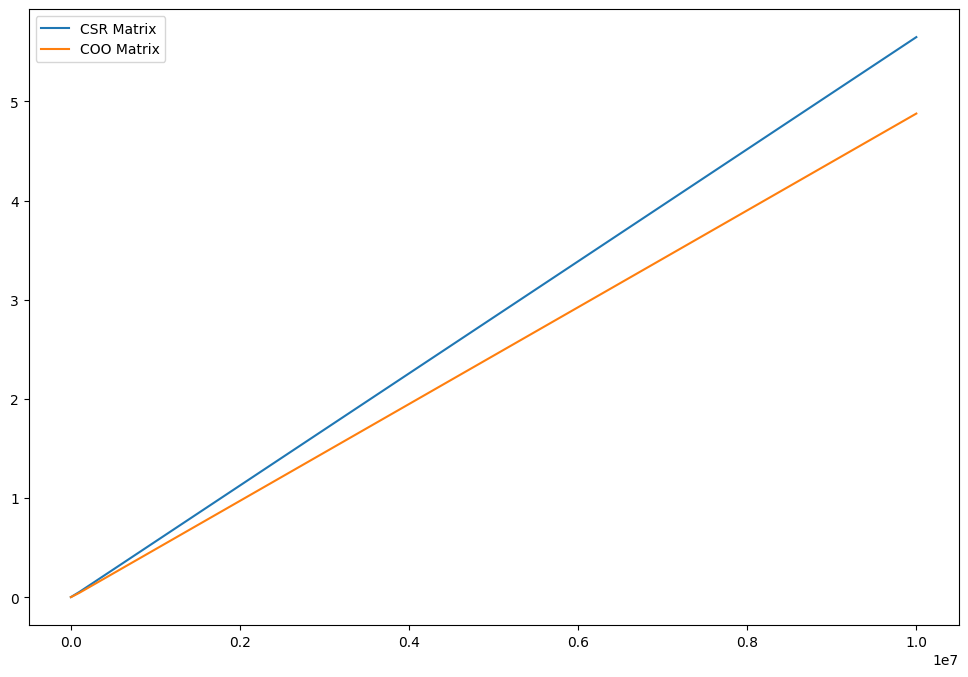

In [98]:
plt.figure()
plt.plot([1000,10000,100000,10000000],t1,label='CSR Matrix')
plt.plot([1000,10000,100000,10000000],t2,label='COO Matrix')
plt.legend(loc='best')

The COO format appears to be optimal as the matrix is so sparse that the quick indexing COO allows makes it faster to use without extra overhead. To check that the matrix creation time does not interfere I will only time the matrix multiplication.

In [104]:
T1=[]
T2=[]
for N in [1000,10000,100000,10000000]:
    sparse1 = sparse_gen_Af(N,format = 'CSR')
    sparse2 = sparse_gen_Af(N,format = 'COO')
    T_1 = %timeit -o -q linalg.spsolve(*sparse1)
    T_2 = %timeit -o -q linalg.spsolve(*sparse2)
    T1.append(T_1.best)
    T2.append(T_2.best)

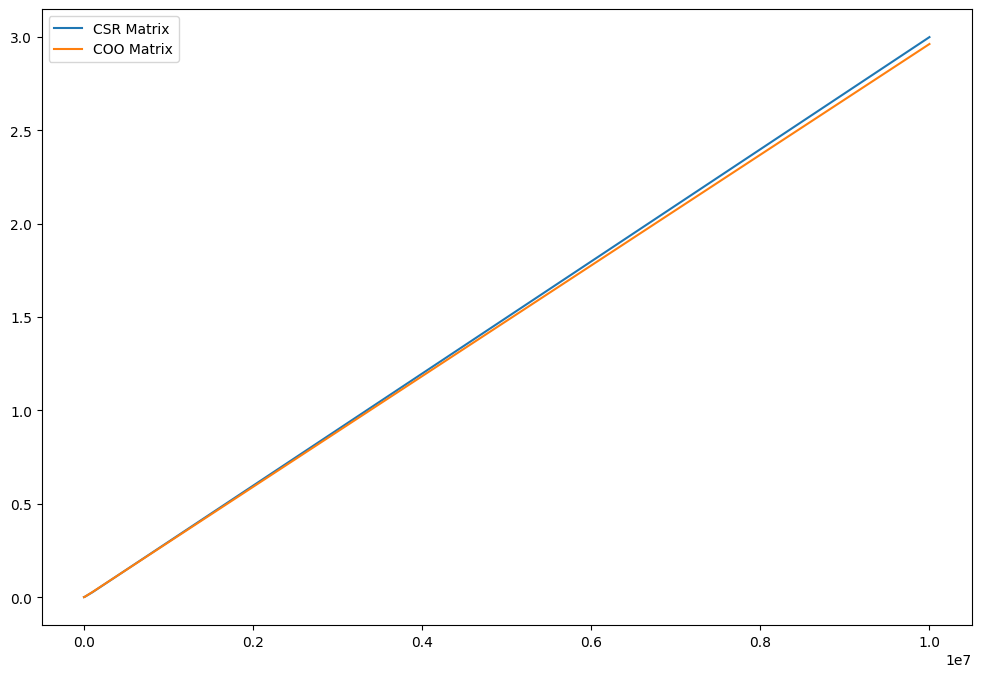

In [105]:
plt.figure()
plt.plot([1000,10000,100000,10000000],T1,label='CSR Matrix')
plt.plot([1000,10000,100000,10000000],T2,label='COO Matrix')
plt.legend(loc='best')

Here they appear to be very similar speeds however the COO matrix format is still slightly faster. Now I will only look at the matrix creation time.

In [106]:
TT1=[]
TT2=[]
for N in [1000,10000,100000,10000000]:
    TT_1 = %timeit -o -q sparse_gen_Af(N,format = 'CSR')
    TT_2 = %timeit -o -q sparse_gen_Af(N,format = 'COO')
    TT1.append(TT_1.best)
    TT2.append(TT_2.best)

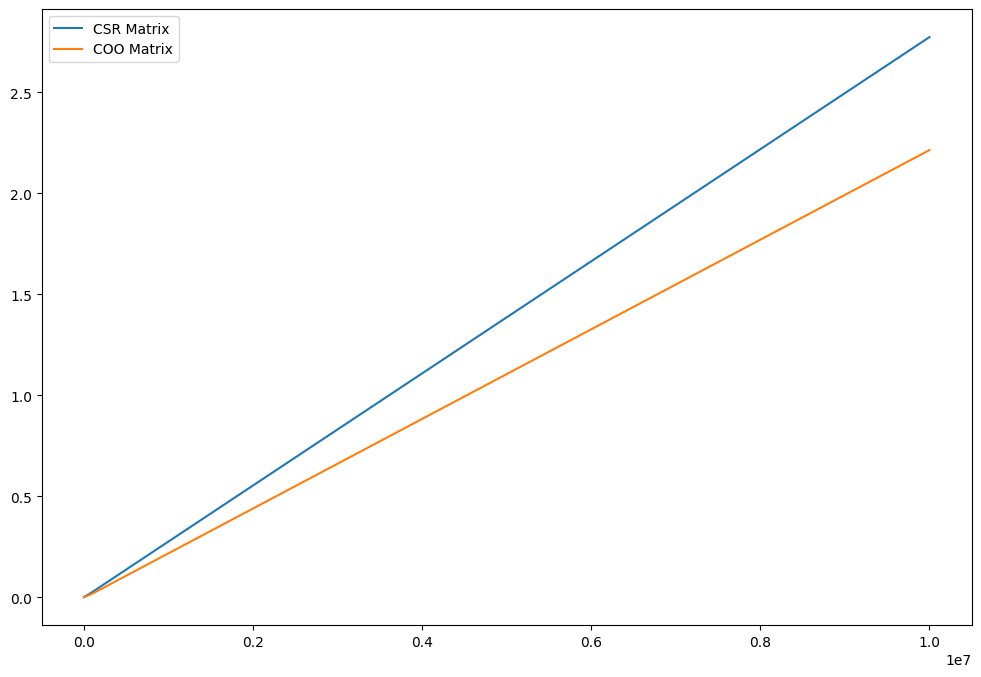

In [107]:
plt.figure()
plt.plot([1000,10000,100000,10000000],TT1,label='CSR Matrix')
plt.plot([1000,10000,100000,10000000],TT2,label='COO Matrix')
plt.legend(loc='best')

The COO matrix format will therefore be utilised. I suspect that as this is a very diagonal matrix, there are not many elements that are in the same rows so there is no benefit to the CSR format.

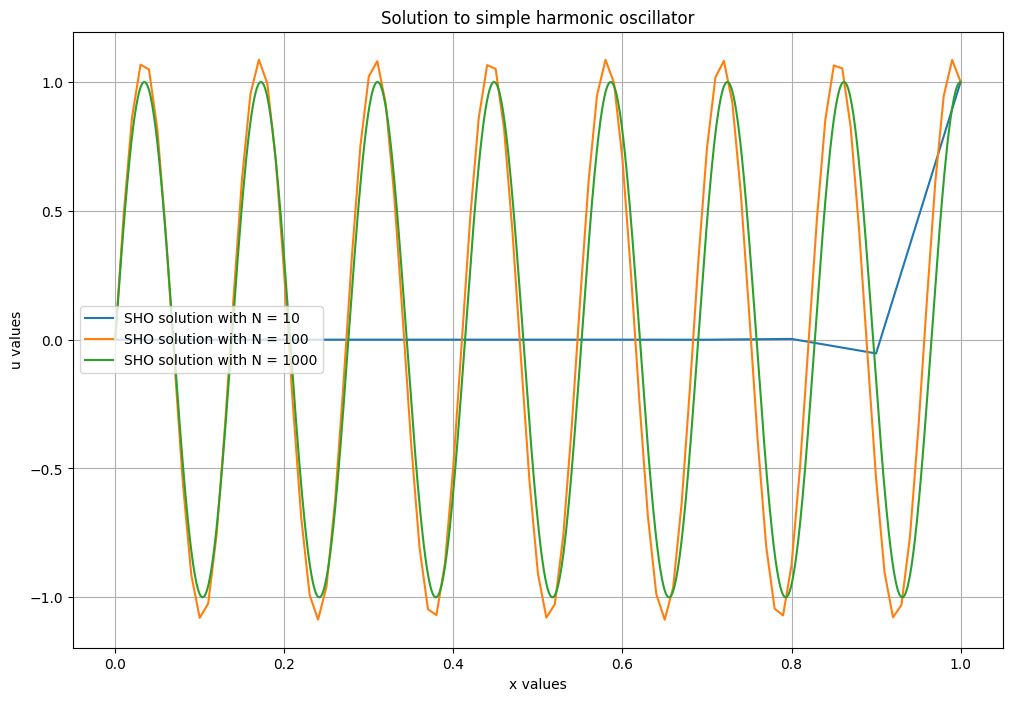

In [29]:
plt.figure()
for N in [10,100,1000]:
    plt.plot(np.linspace(0,1,N+1),
             linalg.spsolve(*sparse_gen_Af(N)),label=f'SHO solution with N = {N}')
plt.xlabel('x values')
plt.ylabel('u values')
plt.title('Solution to simple harmonic oscillator')
plt.grid(True)
plt.legend(loc='best')

It appears that the simple harmonic oscillator with N = 1000 is optimal as it is the most continuous and seems to be the most regular and display the most simple harmonic motion. Solutionn N = 10 appears to not possess any qualities of a simple harmonic oscillator as the length N is not enough for the eigenvalue equation to yield a useful result. I expect the SHO with N = 1000 to be the most similar to the exact solution.

We know that $u_{exact}(x) = sin(x)$. I will measure the error using the equation $\epsilon = max|u_i - u_{exact}(x_i) |$ which is the max residual.

## Error vs N

Below I will plot the $log_{10}$ error vs the $log_{10}$ maximum index N of the matrix. It can be seen that a peak of 1e-8 precision is found before the multiplication starts to become less accurate. This could be due to the accumulation of rounding errors that arise from large amounts of operation. Python uses double precision and not single precision so operations have $\epsilon_{machine}$ of roughly 1e-16.This means that when operations happen over an N = 1e6 scale this error accumulates having a noticable effect on the total error.

In [67]:
def error_plot(N_max_power, freq = 10,init = True,format = 'COO',opt = False):
    N_powerrange = np.linspace(1,N_max_power,freq)#
    N_range = np.array([10**i for i in N_powerrange])
    error = []
    for i in tqdm(N_range):
        x = np.linspace(0,1,int(i)+1)
        A,f = sparse_gen_Af(int(i),format = format)
        result = linalg.spsolve(A,f)
        error.append(max(np.abs(result - np.sin(x*29*np.pi/2))))
    if init:
        plt.figure()
        plt.title('Max Error vs N value')
        plt.xlabel('log N Value')
        plt.ylabel('log Error')
    plt.plot(np.log10(N_range),np.log10(error),label=f'{format} format')
    if opt == True:
        return np.log10(N_range),np.log10(error)

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.57it/s]


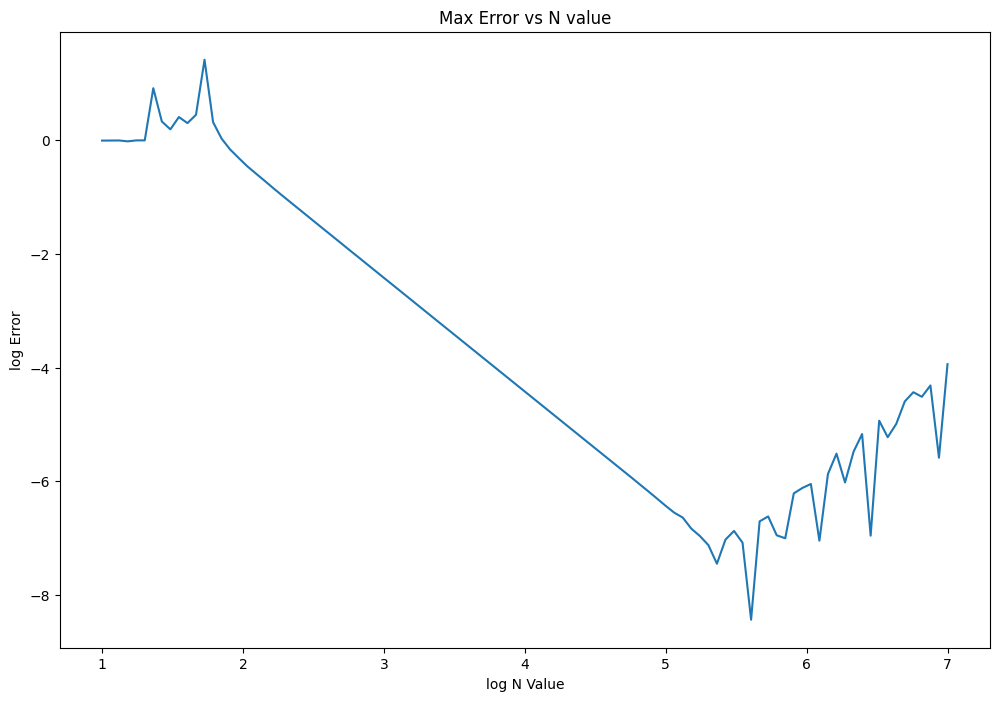

In [21]:
error_plot(7,freq = 100)

It can be seen above that values of n around 1e5.5 are optimal and get the closest to 1e-8 error. Once this point is passed the error seems to increase. This is potentially a result of rounding errors adding up once the number of operations increases. Another factor overhead due to excessive memory usage once the matrix exceeds a certain size.

Now comparing the different matrix formats it can be seen that the result is exactly the same.

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.27it/s]


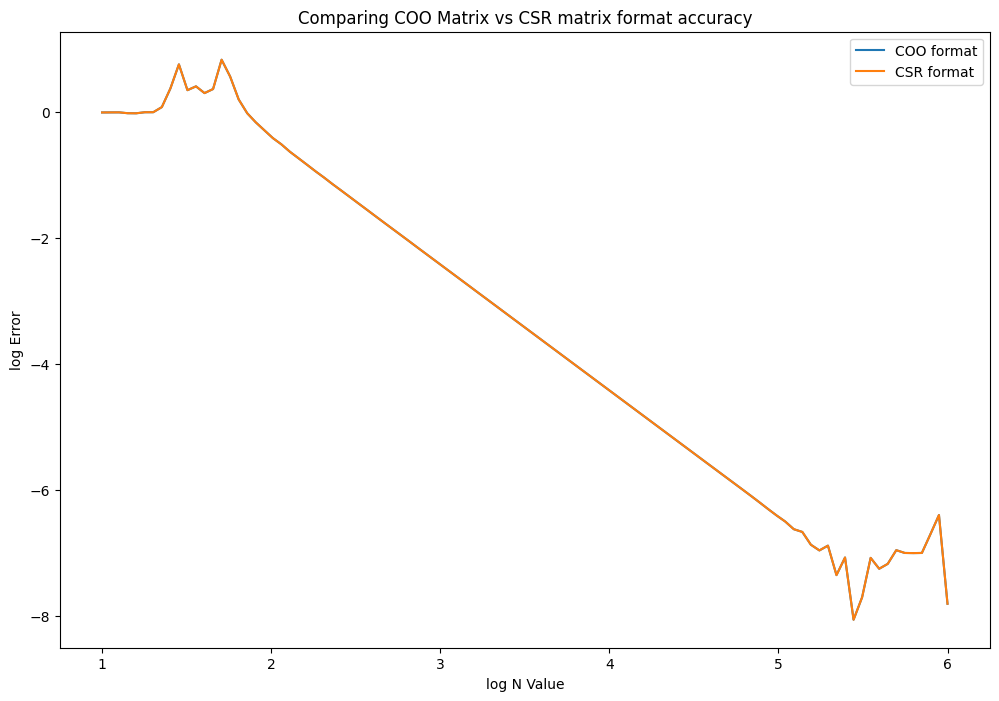

In [22]:
plt.figure()
error_plot(6,freq = 100,init = False,format = 'COO')
error_plot(6,freq = 100,init = False, format = 'CSR')
plt.xlabel('log N Value')
plt.ylabel('log Error')
plt.title('Comparing COO Matrix vs CSR matrix format accuracy')
plt.legend(loc='best')

In [89]:
def time_plot(N_max_power, freq = 10,init = True,format = 'COO',opt = False):
    N_powerrange = np.linspace(1,N_max_power,freq)
    N_range = np.array([10**i for i in N_powerrange])
    time = []
    for i in tqdm(N_range):
        x = np.linspace(0,1,int(i)+1)
        A,f = sparse_gen_Af(int(i),format = format)
        Time = %timeit -o -q linalg.spsolve(A,f)
        time.append(Time.best)
    if init:
        plt.figure()
        plt.title('Time vs N value')
        plt.xlabel('log N Value')
        plt.ylabel('log time')
    plt.plot(np.log10(N_range),np.log10(time),label=f'{format} format')
    if opt:    
        return np.log10(N_range), np.log10(time)

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [12:13<00:00,  7.33s/it]


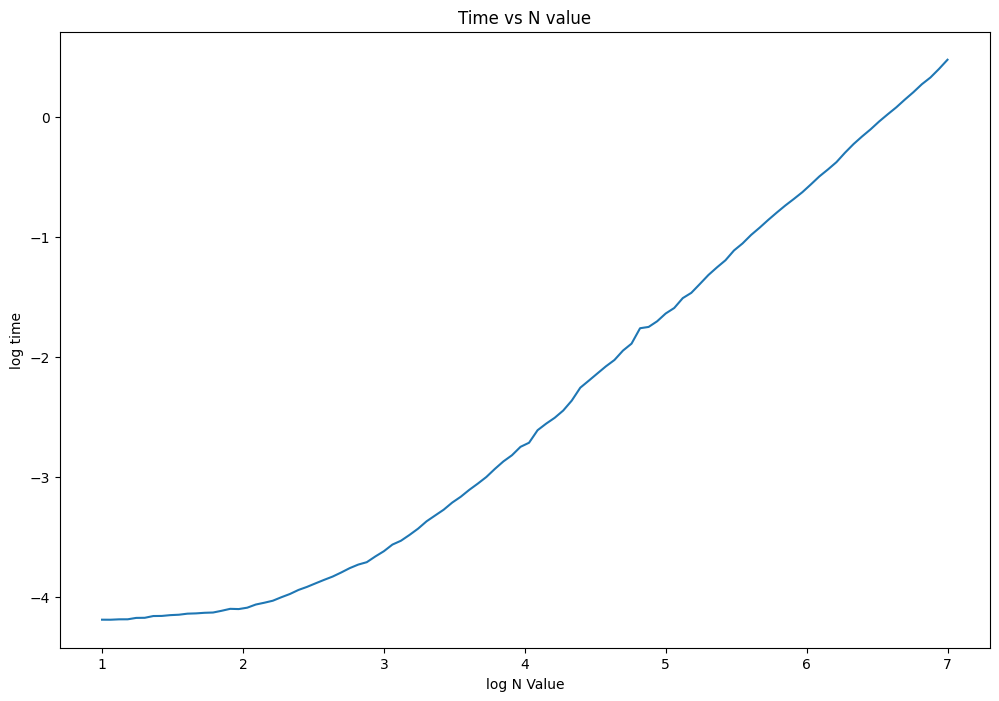

In [91]:
time_plot(7,freq=100)

It can be seen here that $log_{10}$ time vs the $log_{10}$ value appears to be linear for larger log N values but seems to have an exponential increase earlier. This shows that although the log scaling does skew this a bit this method of solving the SMO problem works well over large matrices. The optimal value of $log_10$ N is 5.5. This is the value I would have predicted looking at the linear trend if I did not have access to all the data. This would also have led me to a fairly accurate $log_10$ time result of -1 although the initial trend might have led me to predict a much higher time if I did not just look at the linear fit.

### Predictions

Since the range of N values I ran my code on was large I was able to get the low 1e-8 error through my exploratry graphing. I will now act as if I have not seen the N size required for this accuracy and the time taken and will rediscover this through regression.

In [84]:
a[30:]

array([1.90909091, 1.93939394, 1.96969697, 2.        , 2.03030303,
       2.06060606, 2.09090909, 2.12121212, 2.15151515, 2.18181818,
       2.21212121, 2.24242424, 2.27272727, 2.3030303 , 2.33333333,
       2.36363636, 2.39393939, 2.42424242, 2.45454545, 2.48484848,
       2.51515152, 2.54545455, 2.57575758, 2.60606061, 2.63636364,
       2.66666667, 2.6969697 , 2.72727273, 2.75757576, 2.78787879,
       2.81818182, 2.84848485, 2.87878788, 2.90909091, 2.93939394,
       2.96969697, 3.        , 3.03030303, 3.06060606, 3.09090909,
       3.12121212, 3.15151515, 3.18181818, 3.21212121, 3.24242424,
       3.27272727, 3.3030303 , 3.33333333, 3.36363636, 3.39393939,
       3.42424242, 3.45454545, 3.48484848, 3.51515152, 3.54545455,
       3.57575758, 3.60606061, 3.63636364, 3.66666667, 3.6969697 ,
       3.72727273, 3.75757576, 3.78787879, 3.81818182, 3.84848485,
       3.87878788, 3.90909091, 3.93939394, 3.96969697, 4.        ])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 732.65it/s]


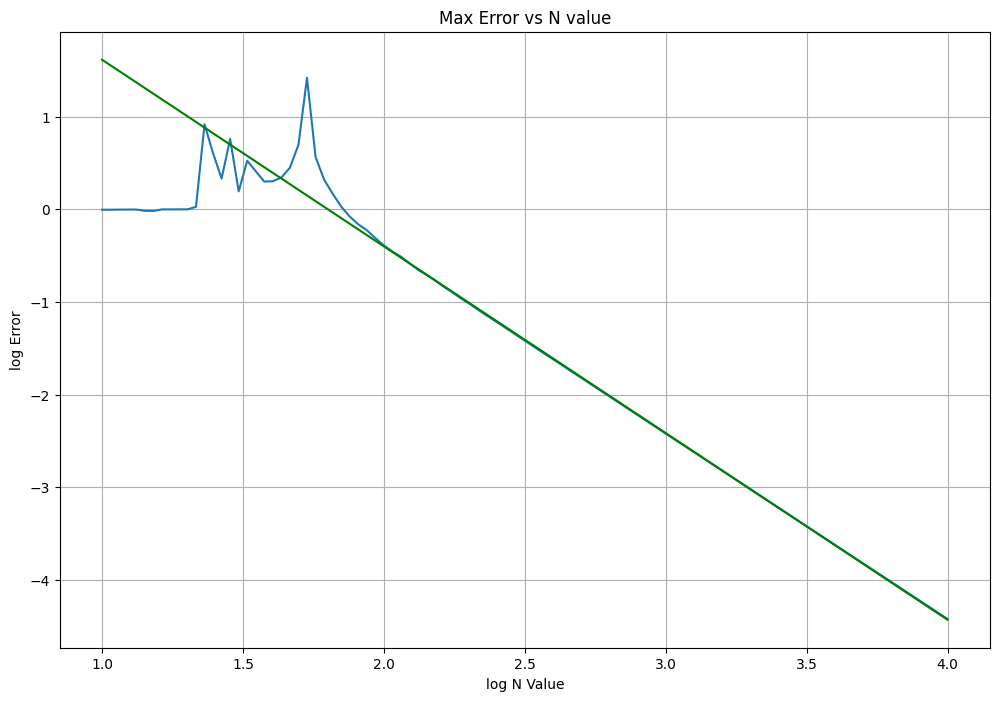

In [85]:
a,b = error_plot(4,freq = 100,opt=True)
plt.grid(True)
A = np.polyfit(a[30:],b[30:],1)
plt.plot(np.linspace(1,4,100),A[0] * np.linspace(1,4,100) + A[1],'-g')

In [86]:
A

array([-2.01367214,  3.62649659])

Therefore the line equation y = m x + c this follows has gradient m = -2.01 and y-intercept c = 3.63. Below I find the $log_{10}$ N value that aligns with 1e-8 error. A value of 5.77 aligns with the extended plot I have.

In [88]:
(-8 - A[1])/A[0]

5.773778356817405

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [12:24<00:00,  7.44s/it]


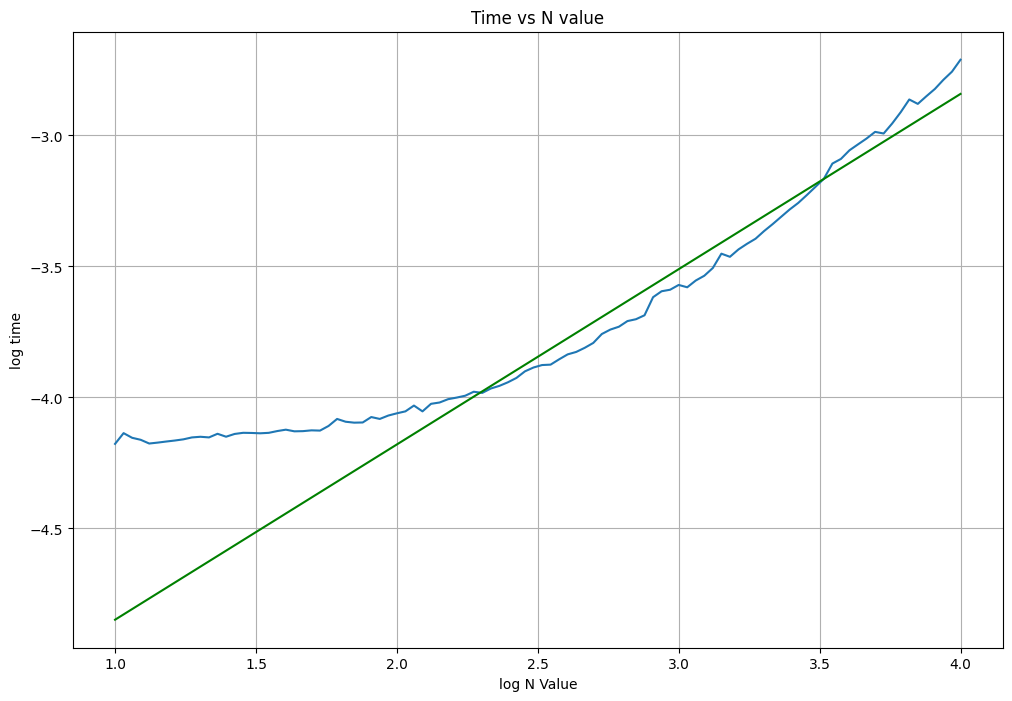

In [91]:
a,b = time_plot(4,freq = 100,opt=True)
plt.grid(True)
B = np.polyfit(a[30:],b[30:],1)
plt.plot(np.linspace(1,4,100),B[0] * np.linspace(1,4,100) + B[1],'-g')

The graph above clearly does not have much of a linear fit for smaller log N values. The gradient is m = 0.669 and the y-intercept is -5.52. The predicted time taken for 1e-8 accuracy is roughly 1e-2. This has a agrees with the previously found times for 1e5.5 values of N which fall between 1e-2 and 1e-1 however the actual value is closer to 1e-1 so the prediction is slightly off.

In [92]:
B

array([ 0.66889529, -5.51721177])

In [93]:
5.5 * B[0] + B[1]

-1.8382876801055081

# Part 2


In this part of the assignment, we want to solve the heat equation

$$
\begin{align*}
\frac{\mathrm{d}u}{\mathrm{d}t} &= \frac{1}{1000}\frac{\mathrm{d}^2u}{\mathrm{d}x^2}&&\text{for }x\in(0,1),\\
u(x, 0) &= 0,&&\text{if }x\not=0\text{ and }x\not=1\\
u(0,t) &= 10,\\
u(1,t) &= 10.
\end{align*}
$$
This represents a rod that starts at 0 temperature which is heated to a temperature of 10 at both ends.

Again, we will approximately solve this by taking an evenly spaced values
$x_0=0, x_1, x_2, ..., x_N=1$.
Additionally, we will take a set of evenly spaced times
$t_0=0,t_1=h, t_2=2h, t_3=3h, ...$, where $h=1/N$.
We will write $u^{(j)}_{i}$ for the approximate value of $u$ at point $x_i$ and time $t_j$
(ie $u^{(j)}_{i}\approx u(x_i, t_j)$).

Approximating both derivatives (similar to what we did in part 1), and doing some algebra, we can rewrite the
heat equation as

$$
\begin{align*}
u^{(j + 1)}_i&=u^{(j)}_i + \frac{u^{(j)}_{i-1}-2u^{(j)}_i+u^{(j)}_{i+1}}{1000h},\\
u^{(0)}_i &= 0,\\
u^{(j)}_{0}&=10,\\
u^{(j)}_{N}&=10.
\end{align*}
$$

This leads us to an iterative method for solving this problem: first, at $t=0$, we set

$$
u^{(0)}_i =
\begin{cases}
10 &\text{if }i=0\text{ or }i=N,\\
0 &\text{otherwise};
\end{cases}
$$
then for all later values of time, we set

$$
u^{(j+1)}_i =
\begin{cases}
10 &\text{if }i=0\text{ or }i=N,\\
\displaystyle u^{(j)}_i + \frac{u^{(j)}_{i-1}-2u^{(j)}_i+u^{(j)}_{i+1}}{1000h} &\text{otherwise}.
\end{cases}
$$


The indices $0 \le i \le N$ correspond to the x values $0 \le x \le 1 $ and the equation for the time is  $t_j = j \times h$. The matrix u will have one (N+1) $\times$ (T+1) with the lengths along the rod representing one dimension and the times representing the other. The values in the matrix represent the heat values.

In [36]:
def gen_U(N,T):
    h = 1/N
    U = np.zeros((T+1,N+1))
    U[0][0] = 10
    U[0][N] = 10
    for j in range(1,T+1):
        U[j][0] = 10
        U[j][N] = 10
        for i in range(N+1):
            if i != 0 and i!= N:
                U[j][i] =U[j-1][i] + (U[j-1][i-1] - 2*U[j-1][i] + U[j-1][i+1])/(1000 * h)
    return U

In [112]:
print(np.around(gen_U(100,100),2))

[[10.    0.    0.   ...  0.    0.   10.  ]
 [10.    1.    0.   ...  0.    1.   10.  ]
 [10.    1.8   0.1  ...  0.1   1.8  10.  ]
 ...
 [10.    8.22  6.52 ...  6.52  8.22 10.  ]
 [10.    8.22  6.54 ...  6.54  8.22 10.  ]
 [10.    8.23  6.55 ...  6.55  8.23 10.  ]]


I will now generate the matrix representing the heat transfer in the rod over time using the function above. I will use a value of 100 as a test and the value for N and will plot for times up to t = 10. Since each timestep is a multiple of h which is 1/N, the more granular out view of the rod, the more granular timesteps we have. The optimal value of N will be found by progressively trying larger values.

In [1]:
def seconds_to_steps(N,t):
    return int(t/(1/N))

In [37]:
def heat_equation_solve(N,times = [1,2,10,20],func = gen_U):
    """
    Plots multiple plots of heat as a function of rod length each with different time value.
    """
    t = seconds_to_steps(N,max(times))
    U = func(N,t)
    plt.figure()
    plt.title('Plot of Heat on Different sections of Rod')
    for i in times:
        plt.plot(U[seconds_to_steps(N,i)],label=f'Heat at time {i}')
    plt.grid(True)
    plt.xlabel('Index on Rod')
    plt.ylabel('Heat Value')
    plt.legend(loc='best')

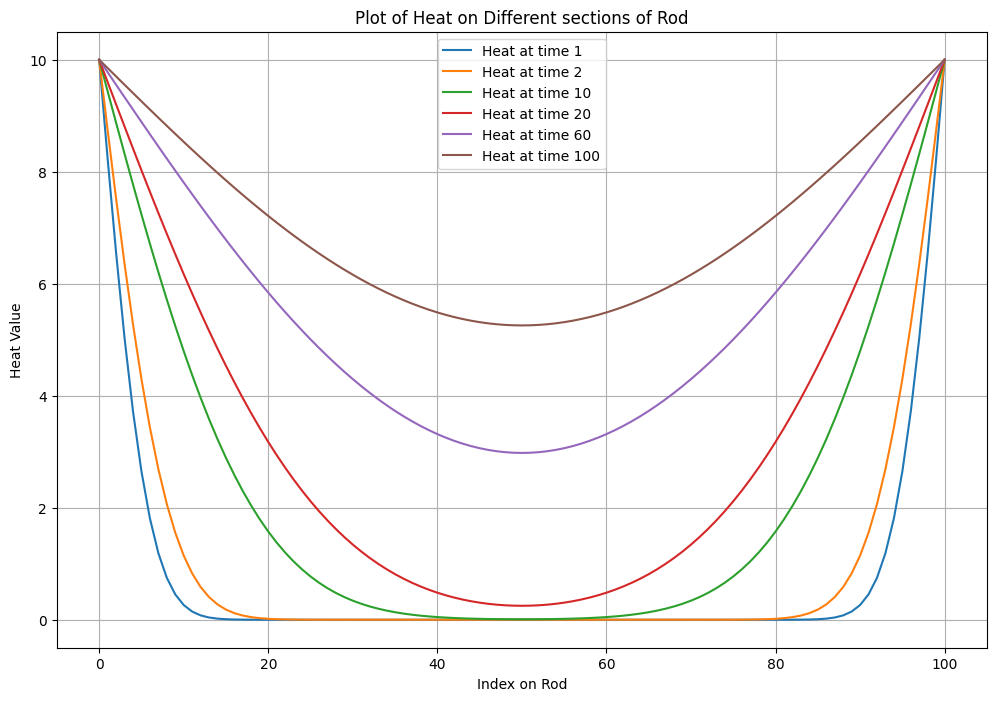

In [9]:
heat_equation_solve(100,times = [1,2,10,20,60,100])

 83%|██████████████████████████████████████████████████████████████████████▊              | 5/6 [00:07<00:02,  2.04s/it]/tmp/ipykernel_2830/2516816216.py:11: RuntimeWarning: overflow encountered in scalar add
  U[j][i] =U[j-1][i] + (U[j-1][i-1] - 2*U[j-1][i] + U[j-1][i+1])/(1000 * h)
/tmp/ipykernel_2830/2516816216.py:11: RuntimeWarning: overflow encountered in scalar subtract
  U[j][i] =U[j-1][i] + (U[j-1][i-1] - 2*U[j-1][i] + U[j-1][i+1])/(1000 * h)
/tmp/ipykernel_2830/2516816216.py:11: RuntimeWarning: invalid value encountered in scalar add
  U[j][i] =U[j-1][i] + (U[j-1][i-1] - 2*U[j-1][i] + U[j-1][i+1])/(1000 * h)
100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:12<00:00,  2.02s/it]


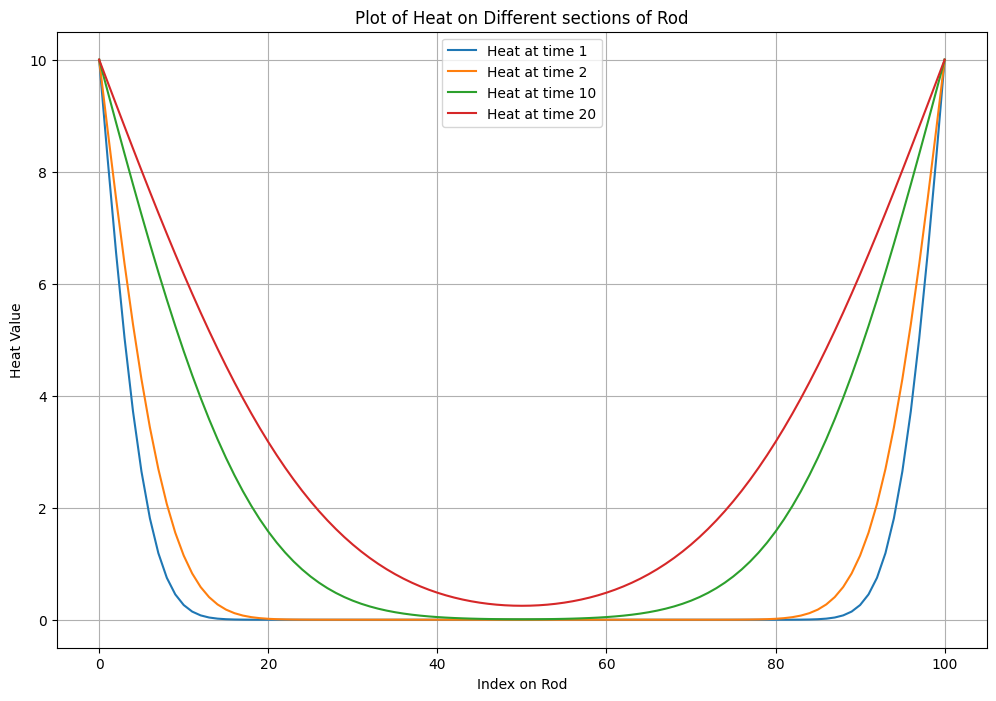

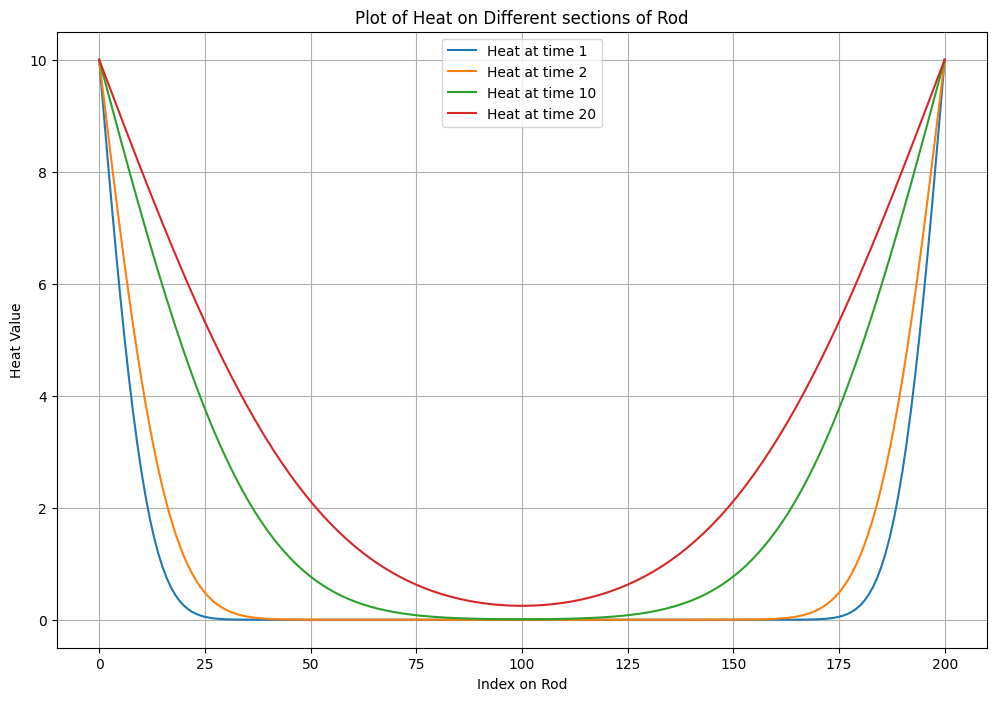

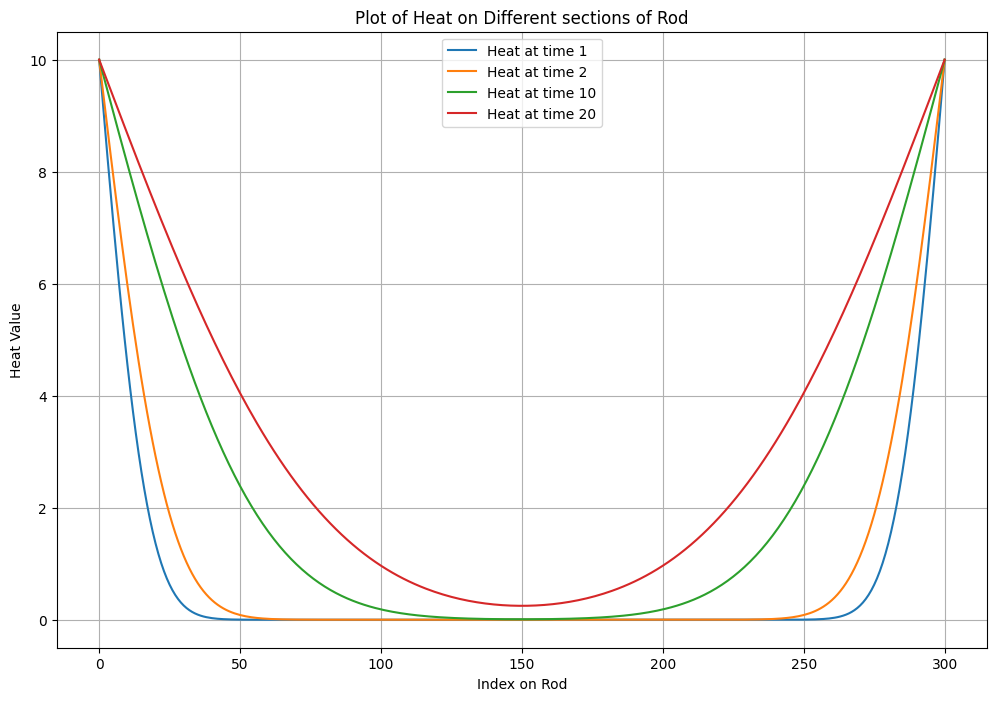

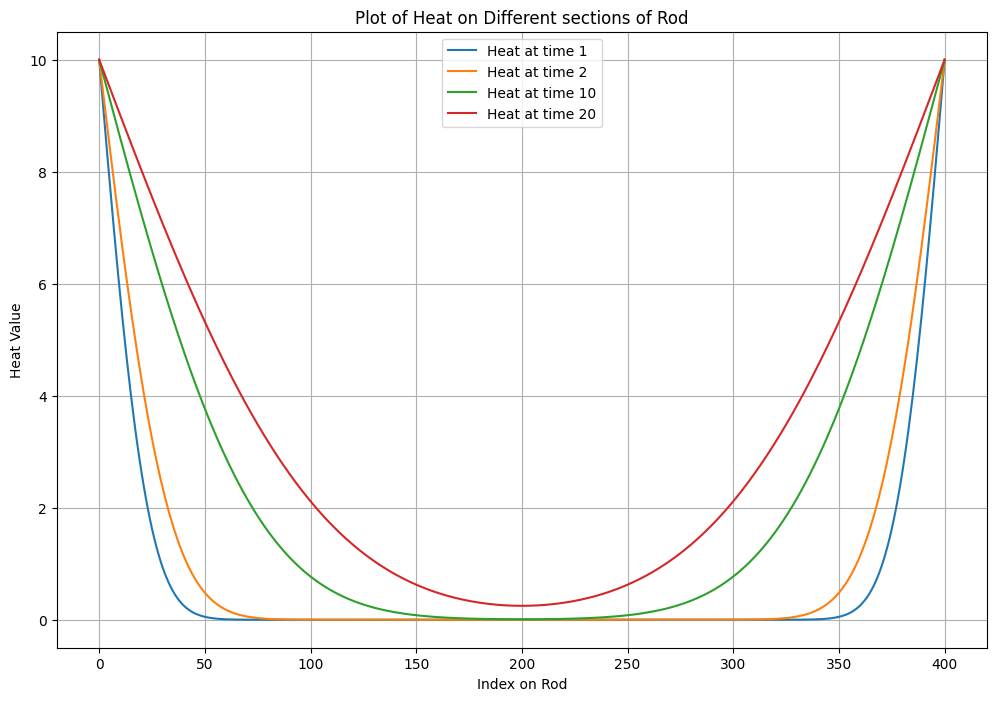

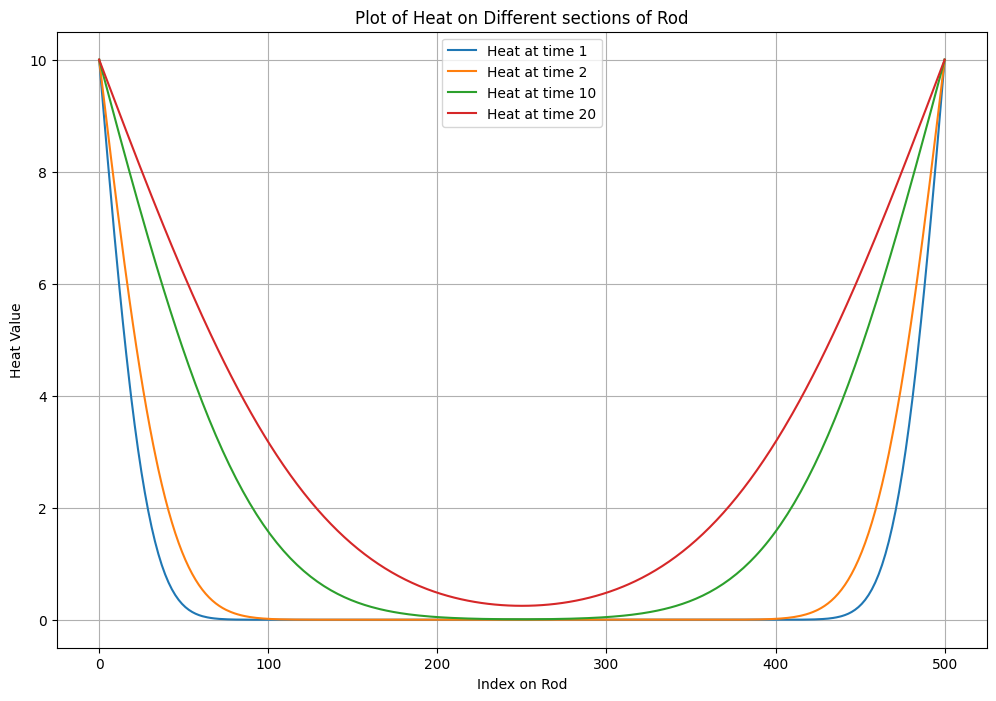

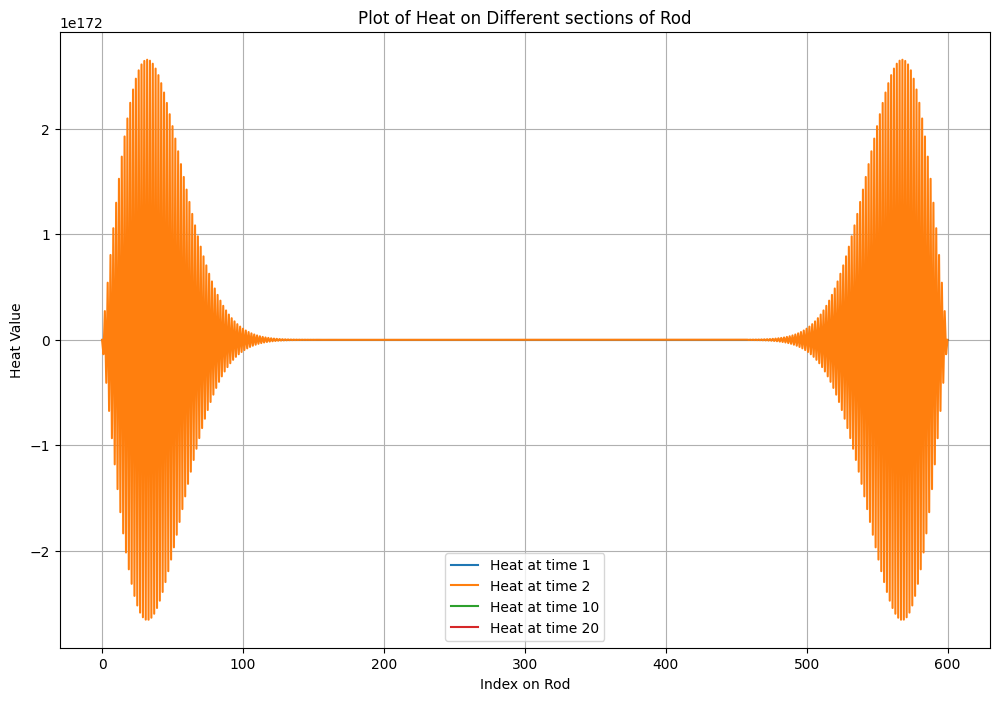

In [104]:
for i in tqdm([100,200,300,400,500,600]):
    heat_equation_solve(i)

The n value I will pick is 500 as when it increases past that the recursion algorithm does not converge on a solution due to how small the timesteps become and how many points there are. I want to pick the largest value possible for N so that the GPU acceleration can be displayed through a more significant speedup. Below it can be seen that even a marginal size increase after 500 results in the heat values becoming highly eccentric and skrocketing to unphysical values. An interesting characteristic the functional graphs have is that they show that heat transfer is faster when there is a bigger heat difference.

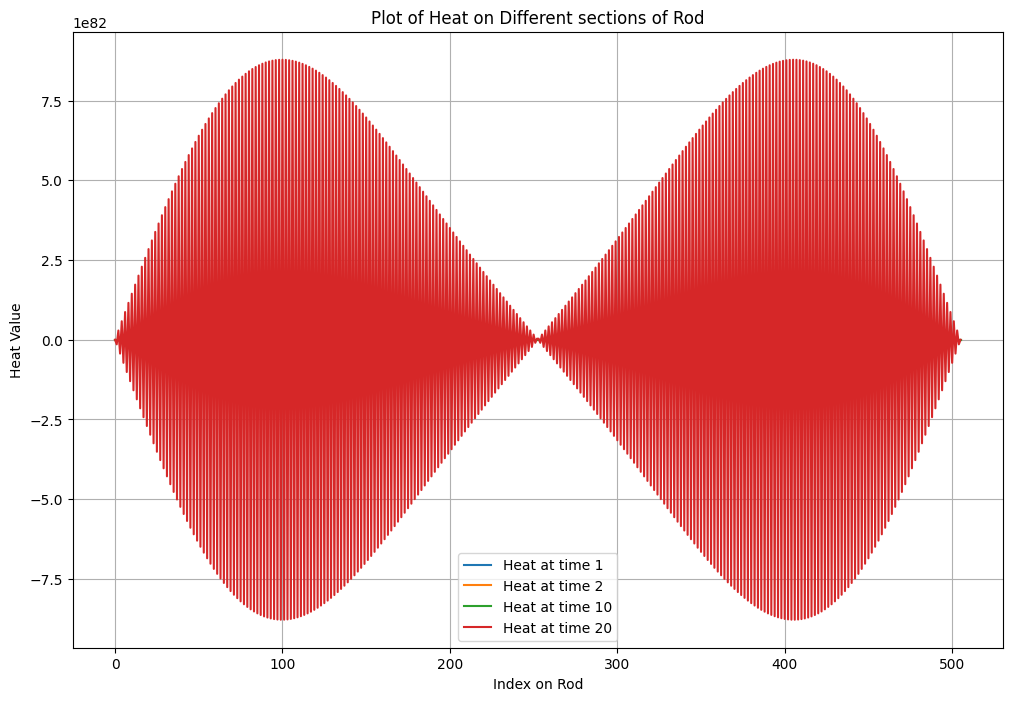

In [106]:
heat_equation_solve(505)

CPU times: user 35.1 s, sys: 2.88 ms, total: 35.1 s
Wall time: 35.1 s


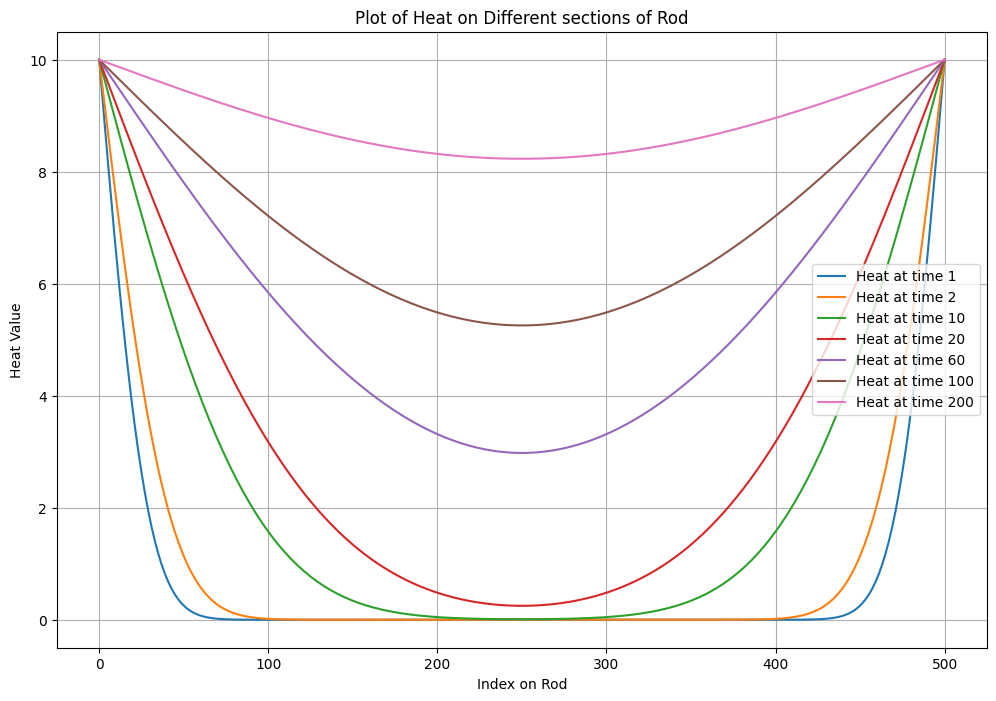

In [38]:
%%time
heat_equation_solve(500,times = [1,2,10,20,60,100,200])

It appears that at time 200 the heat value exceeds 8. I will now plot the temperatures of the rod midpoints against time: 

In [4]:
def heat_equation_solve_mid(N, maxtime = 300):
    """
    Plots the heat of the centre of the rod against time.
    Inputs:
        N - Maximum index of rod length.
        maxtime - max value that the time unit has
    Returns:
        None
    """
    t = seconds_to_steps(N,maxtime)
    U = gen_U(N,t)
    plt.figure()
    plt.title('Plot of Heat on Rod midpoint against Time')
    plt.plot(np.linspace(0,maxtime,t+1),U[:,N//2])
    plt.grid(True)
    plt.xlabel('Time')
    plt.ylabel('Heat Value')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


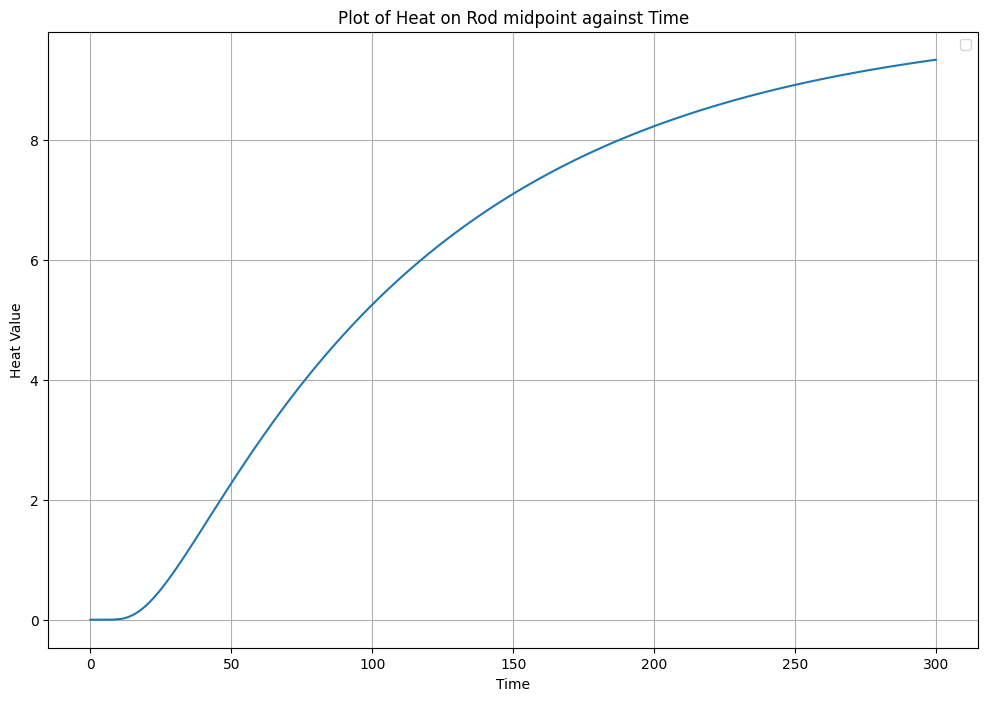

In [116]:
heat_equation_solve_mid(500)

It can be seen here that there is an initial exponential increase in the time taken to increase heat until there is a plateau around the 300 mark meaning that it will take a lot of time to reach. I will now plot replot this using gpu computing. During my research I found that numba.cuda does not behave well with excessive parametrized array sizes so I will preset them here. I will set N to its maximum value to demonstrate the speed up of the cuda implementation as compared to the pure python implementation.

## GPU Cuda implementation

My previous code functions by iterating through each timestep that the heat equation is being solved for and then iterating though each cooridinate on the rod. This is more inefficient than it needs to be as the iterations along the rod can be carried out in parallel as they are independent. This then opens the door to GPU utilisation as GPUs have smaller but more much more numerous cores than CPUs. This means that although CPUs are better for sequential computationally expensive tasks GPUs are vastly superior for vectorised operations where each individual process is less expensive. Since memory transfers between GPUs memory and system memory are not desired due to low bus transfer speeds computational operations that are very memory bound are less desired. Therefore we want to transfer information to and from the GPU as few times as possible which is why a singular two dimensional array format is used. Each row in the matrix $\textbf{u}$ represents a point in time so as the rows are iterated through the whole row is stored in shared meory while N + 1 threads are distributed amongst the indidcies on the rod where the thread calcualtes the subsequent value correlation to $j+1$.

In [117]:
cuda.detect()

Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 4080 Laptop GPU'                              [SUPPORTED]
                      Compute Capability: 8.9
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-fd379373-cb0e-3919-1348-de7d0ad0744c
                                Watchdog: Enabled
             FP32/FP64 Performance Ratio: 64
Summary:
	1/1 devices are supported


True

/home/gsaba/.local/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


CPU times: user 1.44 s, sys: 837 ms, total: 2.27 s
Wall time: 2.46 s


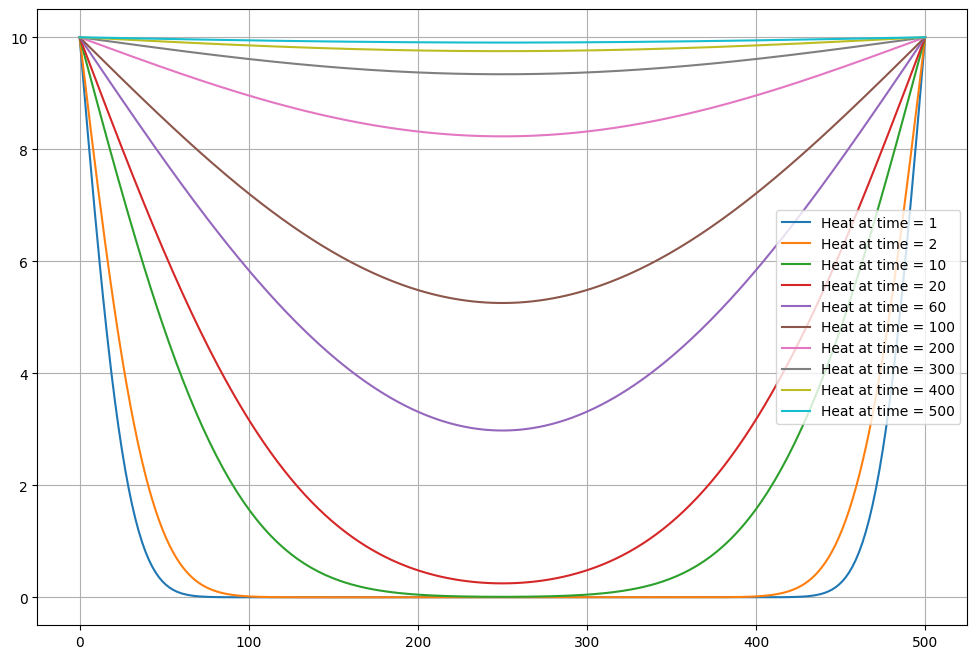

In [42]:
%%time
TIMES = [1,2,10,20,60,100,200,300,400,500]
N = 500
T = seconds_to_steps(N,max(TIMES))
h = 1/N
#threads per block and blocks per grid
#max tpb is 1024. Heat solution fails after 500 size so can keep tpb as N + 1 and bpg as 1
tpb = N+1
bpg = 1

@cuda.jit
def create_u_worker(U):
    """
    Input pre-existing U so that the contents of this cuda compiled function have minimal numpy influence. Stores value to GPU which can then be retreived.
    Input:
        U - preset matrix which is (T+1) by (N+1)
    Output:
        None
    """
    x = cuda.grid(1)
    s = cuda.shared.array(tpb,numba.float32)
    for j in range(T):
        s[x] = U[j,x]
        cuda.syncthreads()
        if x == 0:
            U[j+1,x] = numba.float32(10)
        elif x == N:
            U[j+1,x] = numba.float32(10)
        else:
            U[j+1, x] = s[x] + (s[x-1] - 2*s[x] + s[x+1]) / numba.float32(1000 * h)    ##indexing has also changed. 
        cuda.syncthreads()                                                              ##Updating one increment ahead the for loop from current instead of current from previous

u = np.zeros((T+1, N+1))
u[0, 0] = 10
u[0, N] = 10
result = cuda.to_device(u.astype('float32'))


create_u_worker[bpg, tpb](result)

# retrieve from device
u = result.copy_to_host()

plt.figure()
for i in TIMES:
    plt.plot(u[seconds_to_steps(N,i)],label=f'Heat at time = {i}')
plt.legend(loc='best')
plt.grid(True)

Text(0, 0.5, 'Heat Value')

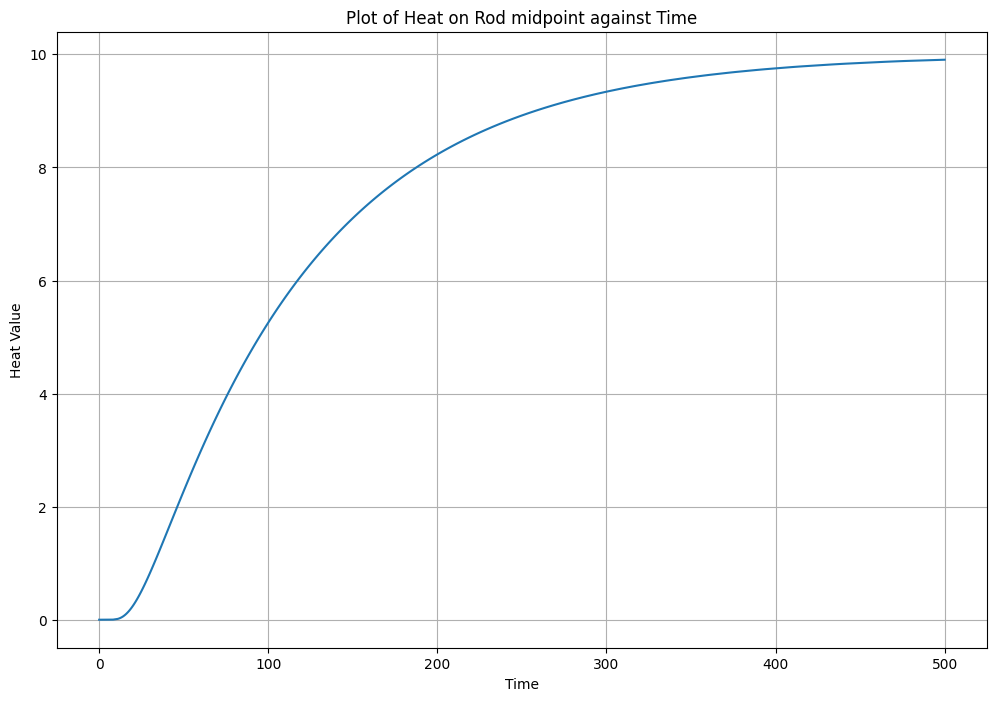

In [46]:
plt.figure()
plt.title('Plot of Heat on Rod midpoint against Time')
plt.plot(np.linspace(0,TIMES[-1],T+1),u[:,N//2])
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Heat Value')

The above plot continues the trend of the plateau experienced in the non accelerated code as expected but has managed to compute a much larger time period over a much shorter period of time. For comparison the gpu accelerated calculation calculated the heat for 2.5 times the timesteps in less than a tenth of the time. It should also be noted that the larger matrices are the exponentially more computational resources it needs. The plot below reaches an accuracy which is far above that of 9.8 before it plateaus near 10. At t = 400 I estimate the Heat value to be 9.8.

Below I have written a simple for loop that ends and prints the index when the heat is within a tolerance of 1e-5. When T = 9.8 it can be seen below that the time is 423.

In [59]:
for i,val in enumerate(u[:,N//2]):
    if np.allclose(val,9.8):
        print(i)
        break

210964


In [60]:
print(f'At value {u[:,N//2][210964]} the time is {np.linspace(0,TIMES[-1],T+1)[210964]}.')

At value 9.799903869628906 the time is 421.928.


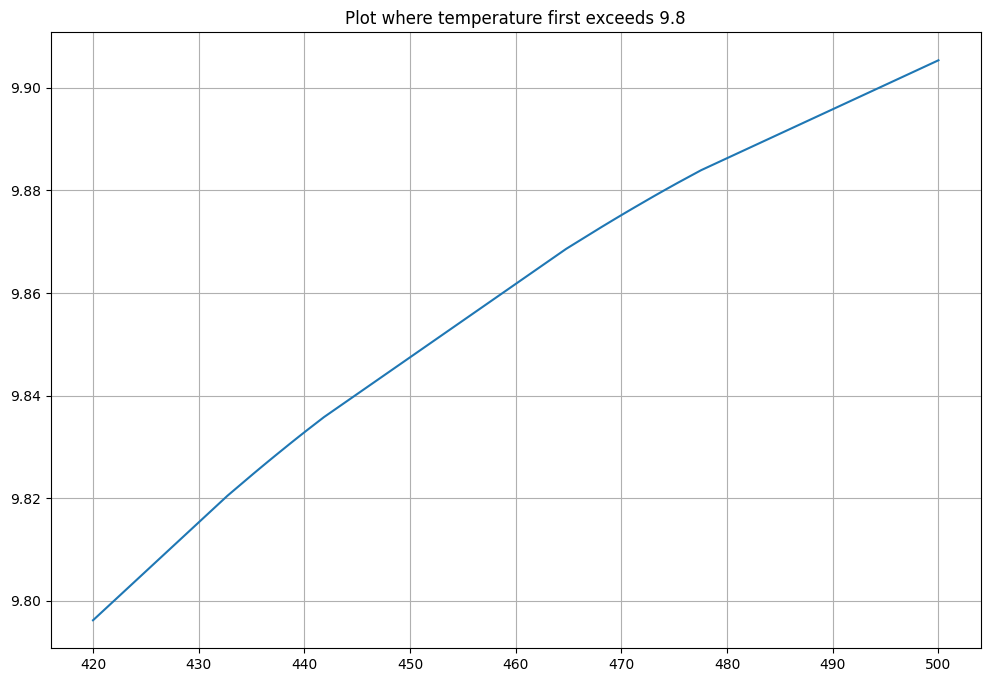

In [61]:
plt.figure()
plt.title('Plot where temperature first exceeds 9.8')
plt.plot(np.linspace(0,TIMES[-1],T+1)[210000:],u[:,N//2][210000:])
plt.grid(True)